Un GAN (Generative Adversarial Network) est constitué de deux réseaux neuronaux qui s’affrontent dans un processus d’apprentissage :

Le générateur : il crée des données synthétiques à partir d’un bruit aléatoire. Son objectif est de produire des données qui ressemblent le plus possible aux données réelles.
Le discriminateur : il tente de distinguer les données réelles des données générées par le générateur.
Ces deux réseaux sont en compétition :

Le générateur essaie de tromper le discriminateur en produisant des données de plus en plus réalistes.
Le discriminateur s'améliore progressivement pour mieux différencier les vraies données des fausses.
Ce processus se poursuit jusqu’à ce que le générateur parvienne à créer des données si réalistes que le discriminateur ne puisse plus les distinguer des vraies données.

CTGAN (Conditional Tabular GAN) est un modèle spécialisé dans la génération de données tabulaires synthétiques. Contrairement aux GANs classiques, il prend en compte la nature discrète et continue des variables dans un tableau, ce qui le rend plus efficace pour les bases de données structurées.

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import precision_score, recall_score, f1_score,\
                            #accuracy_score, balanced_accuracy_score,classification_report,\
                            #plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle

np.random.seed(1635848)

2025-03-05 23:48:32.140280: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-05 23:48:32.144388: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-05 23:48:32.158275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741218512.177024   58341 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741218512.185581   58341 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-05 23:48:32.205940: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [17]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tensor = tf.constant([1, 2, 3])
numpy_array = tensor.numpy()

In [ ]:

class cGAN():
    
    """
    "Classe contenant 3 méthodes (et init) : générateur, discriminateur et entraînement. 
    Le générateur est entraîné en utilisant du bruit aléatoire 
    et un label comme entrées. Le discriminateur est entraîné en utilisant 
    des échantillons réels/faux et des labels comme entrées."
    
    """
    
    def __init__(self,latent_dim=32, out_shape=43):
        
        self.latent_dim = latent_dim
        self.out_shape = out_shape 
        #self.num_classes = 1
        # Utilisation de Adam comme optimizer
        optimizer = Adam(0.0002, 0.5) #mettre à jour les poids d'un réseau de neurones pendant l'entraînement
        
        # construction du discriminateur
        self.discriminator = self.discriminator()
        #définission de la fonction de perte, l'optimiseur et les métriques à utiliser pour l'entraînement
        self.discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # Construction du générateur
        self.generator = self.generator()
        noise = Input(shape=(self.latent_dim,))
        condition = Input(shape=(1,))
         #le générateur prend à la fois le bruit aléatoire et le label comme entrée pour générer des échantillons (gen_samples)
        gen_samples = self.generator([noise, condition]) 
        
        # désactivation de l'entraînement du discriminateur lorsque le générateur est entraîné
        self.discriminator.trainable = False

        #probabilité qui indique si le discriminateur pense que l'échantillon généré est réel
        valid = self.discriminator([gen_samples, condition])

        #tentative du générateur de tromper le discriminateur en produisant des échantillons aussi réalistes que possible

        # combinaison des 2 modèles
        self.combined = Model([noise, condition], valid)
        
        self.combined.compile(loss=['binary_crossentropy'],
                              optimizer=optimizer,
                             metrics=['accuracy'])

    def generator(self):
        #initialise les poids des couches du générateur en utilisant une distribution normale avec une moyenne de 0 et un écart type de 0.02
        init = RandomNormal(mean=0.0, stddev=0.02)
        # les couches seront empilées les unes après les autres de manière linéaire.
        model = Sequential()

        # Une couche de 128 neurones est crée
        model.add(Dense(128, input_dim=self.latent_dim))
        # 20% des neurones sont éteints lors de l'entrainement 
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2)) #fonction d'activation
        model.add(BatchNormalization(momentum=0.8))
        
        # Ajout de nouvelles couches
        model.add(Dense(256))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        #couche finale
        model.add(Dense(self.out_shape, activation='tanh'))

        #création du bruit et du label conditionnel
        noise = Input(shape=(self.latent_dim,))
        #label = Input(shape=(1,), dtype='int32')
        #transforme les labels en vecteurs d'embedding de taille latent_dim
        #label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
        condition = Input(shape=(1 ,))
        
        model_input = multiply([noise, condition]) # Combinaison du bruit et de la condition
        gen_sample = model(model_input)

        return Model([noise, condition], gen_sample, name="Generator")

    #De même on crée le discriminateur

    def discriminator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(512, input_dim=self.out_shape, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Dense(256, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Dense(128, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        #dernière couche a 1 neurone
        model.add(Dense(1, activation='sigmoid'))
        
        gen_sample = Input(shape=(self.out_shape,))
        condition = Input(shape=(1, ))
        #condition = Input(shape=(1,), dtype='int32')
        #label_embedding = Flatten()(Embedding(self.num_classes, self.out_shape)(label))
        model_input = multiply([gen_sample, condition])

        #donne score entre 0 et 1
        validity = model(model_input)

        return Model(inputs=[gen_sample, condition], outputs=validity, name="Discriminator")
    
    def train(self, real_data, real_conditions, epochs, batch_size=32,sample_interval=100, plot=True): 
        
       #Les listes vont stocker les pertes du générateur et du discriminateur à chaque époque
        global G_losses
        global D_losses
        
        G_losses = []
        D_losses = []

       #l'étiquette pour un échantillon réel est définie à 1, indiquant que l'échantillon est authentique
        # labels des échantillons réels, utilisés pour entraîner le discriminateur
        valid = np.ones((batch_size, 1))
        # labels des échantillons générés, utilisés pour entraîner le discriminateur considérs comme faux
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            
            idx = np.random.choice(len(real_conditions), batch_size)
            real_prices = real_data.iloc[idx]
            conditions = real_conditions[idx]
            
            print(real_prices.shape)

            #récupération des échantillons et des labels à partir des indices
            #samples, labels = X_train[idx], y_train[idx]
            #mélange
            real_prices, conditions = shuffle(real_prices, conditions)
            
            # Génération du bruit
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            #génération de échantillons "faux" par le générateur
            gen_samples = self.generator.predict([noise, conditions])
           # print(gen_samples)
            print(gen_samples.shape)


            # label smoothing: les labels des échantillons réels sont légèrement modifiés pour les rendre moins parfaits, et les labels des échantillons générés sont légèrement améliorés
            # pour éviter un apprentissage trop rapide et éviter que le modèle ne devienne trop confiant
            if epoch < epochs//1.5:
                valid_smooth = (valid+0.1)-(np.random.random(valid.shape)*0.1)
                fake_smooth = (fake-0.1)+(np.random.random(fake.shape)*0.1)
            else:
                valid_smooth = valid 
                fake_smooth = fake
                
            # Entraînement du discriminateur
            self.discriminator.trainable = True #activation de l'entraînement du disciminateur
            d_loss_real = self.discriminator.train_on_batch([real_prices, conditions], valid_smooth) # Entraîner sur les échantillons réels
            d_loss_fake = self.discriminator.train_on_batch([gen_samples, conditions], fake_smooth) # Entraîner sur les échantillons générés
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # Calculer la perte globale du discriminateur: moyenne des pertes réelles et générées, pondérée par 0.5
            print(d_loss)

 
         #d_loss_real : La perte pour les échantillons réels est calculée en fonction des valid_smooth (les labels lissés des échantillons réels).
         #d_loss_fake : La perte pour les échantillons générés est calculée en fonction des fake_smooth (les labels lissés des échantillons générés)."


            # Entrainement du générateur
            self.discriminator.trainable = False #désactive l'entraînement du discriminateur

            #on recompile le modèle

            self.combined.compile(optimizer='adam', loss='binary_crossentropy')
            g_loss = self.combined.train_on_batch([noise, conditions], valid)
            print(g_loss)

          #Afficher les pertes
            if (epoch+1)%sample_interval==0:
                print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, epochs, d_loss[0], g_loss[0]))
            G_losses.append(g_loss[0])
            D_losses.append(d_loss[0])
            if plot:
                if epoch+1==epochs:
                    plt.figure(figsize=(10,5))
                    plt.title("Generator and Discriminator Loss")
                    plt.plot(G_losses,label="G")
                    plt.plot(D_losses,label="D")
                    plt.xlabel("iterations")
                    plt.ylabel("Loss")
                    plt.legend()
                    plt.show()






In [5]:
data=pd.read_csv("EUR_4Q24_EUR.csv",sep=";", encoding="utf-8")
data = data.replace(',', '.', regex=True).astype(float)

In [6]:
data.columns = data.columns.str.replace(' ', '_')

print(data)

     Scenario  Time_Step  EUR_Nom_Spot_1  EUR_Nom_Spot_2  EUR_Nom_Spot_3  \
0         1.0        0.0        0.023360        0.021924        0.021930   
1         1.0        1.0        0.004213        0.004662        0.005203   
2         1.0        2.0        0.003470        0.004038        0.004465   
3         1.0        3.0        0.005811        0.006172        0.006726   
4         1.0        4.0        0.006319        0.007029        0.007629   
..        ...        ...             ...             ...             ...   
405      10.0       36.0        0.014703        0.014170        0.013539   
406      10.0       37.0        0.007944        0.007294        0.006586   
407      10.0       38.0       -0.000385       -0.001076       -0.001832   
408      10.0       39.0       -0.004658       -0.005440       -0.006024   
409      10.0       40.0       -0.003143       -0.003553       -0.003910   

     EUR_Nom_Spot_4  EUR_Nom_Spot_5  EUR_Nom_Spot_6  EUR_Nom_Spot_7  \
0          0.022

In [7]:
X=data.drop("Time_Step", axis=1)
X=data.drop("Scenario", axis=1)
y=data["Time_Step"].values

X_train, X_test, condition_train, condition_test = train_test_split(X, y, test_size=0.2)

In [8]:
condition_train=condition_train.reshape(-1,1)


In [33]:
cgan=cGAN()


(32, 43)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
(32, 43)
[0.6403327 0.       ]
[array(0.71646464), array(0.5625)]
(32, 43)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
(32, 43)
[0.53085867 0.        ]
[array(0.72995722), array(0.546875)]
(32, 43)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
(32, 43)
[0.47662103 0.        ]
[array(0.76618624), array(0.51041669)]
(32, 43)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
(32, 43)
[0.4200926 0.       ]
[array(0.82737058), array(0.4609375)]
(32, 43)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
(32, 43)
[0.38300146 0.        ]
[array(0.81196856), array(0.42500001)]
(32, 43)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
(32, 43)
[0.34165633 0.        ]
[array(0.95022714), array(0.390625)]
(32, 43)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
(32, 43)
[0.31592959 0.        ]
[array(1.0459832), array(0.34375)]
(32, 43)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
(32, 43)
[0.29344226 0.        ]
[array(1.0504899), array(0.30859375)]
(32, 43)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
(32, 43)
[0.2645390

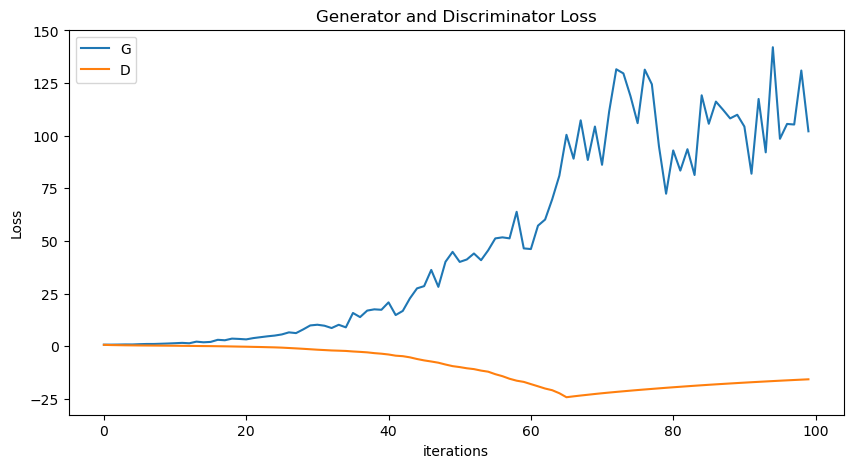

In [34]:

cgan.train(X_train, condition_train, epochs=100, batch_size=32)